# Canny Edge Detection

Submitted by: Ephi Frankel



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread 


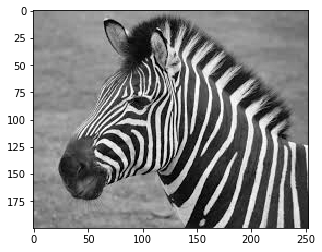

In [2]:
# lets start with our zebra  image:
img = imread('zebra.jpeg','L')

plt.imshow(img, cmap='gray',interpolation='nearest')
plt.show()

## step 1: smooth with a Gaussian filter:

(use your `filter2D` function from exercise 2)


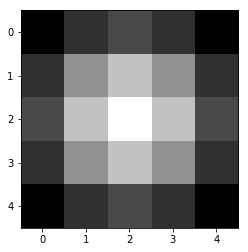

In [3]:
def gaussian(n,sigma):
    # generates a Gaussian kernel of size (2n+1)*(2n+1)
    x = np.arange(-n,n+1)
    y = np.arange(-n,n+1)
    xx, yy = np.meshgrid(x,y)
    z = np.exp(-(xx**2+yy**2)/(2*sigma**2))
    z = z/z.sum()
    return z
               
gaussian_kernel = gaussian(2, 1.5)            
plt.imshow(gaussian_kernel, cmap='gray')
plt.show()


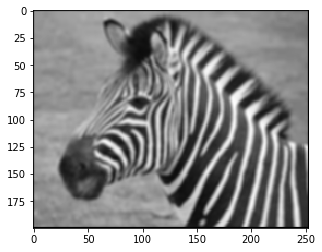

In [4]:
def filter2D(img_in, kernel):
    
    # check kernel dimensions
    ker_h, ker_w = kernel.shape
    if ker_h != ker_w:
        raise ValueError('expected square-size kernel')
    if ker_h%2==0:
        raise ValueError('expected odd-size kernel')   
    n = int((ker_h-1)/2)
   
  
    # [your code here...]
    w = (img_in.shape[0] + 2*n)
    
    h = (img_in.shape[1] + 2*n)
    img_tmp = np.zeros((w,h))
    img_tmp[n:-n,n:-n] = img_in
    x_end = img_in.shape[0]+1
    y_end = img_in.shape[1]+1
    img_out = np.zeros((img_in.shape[0],img_in.shape[1]))
    for x in range(n,x_end):
        for y in range(n,y_end):
            img_out[x-n,y-n] = (img_tmp[x-n:x-n+ker_h,y-n:y-n+ker_w]*kernel).sum()
    return img_out


Z = filter2D(img, gaussian_kernel)
plt.imshow(Z, cmap='gray')
plt.show()


## step 2: calculate gradients 

a) use 3x3 Sobel operators (Sx and Sy) to calculate Gx and Gy. 

b) from Gx and Gy generate the magnitudes map (G) and the directions map (theta)



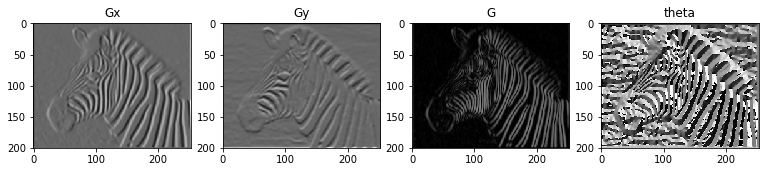

In [5]:
# 3x3 Sobel operators (Sx and Sy) to calculate Gx and Gy. 
SxWithSmooth = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]])
SyWithSmooth = SxWithSmooth.T
Gx = filter2D(Z, SxWithSmooth)
Gy = filter2D(Z, SyWithSmooth)
#Gx and Gy generate the magnitudes map (G) and the directions map (theta)
G = np.sqrt(Gx**2 + Gx**2)
theta = np.arctan2(Gy,Gx)
# plot the results (Gx,Gy,G and theta)
imgs = [Gx,Gy,G,theta]
imgNames = ['Gx','Gy','G','theta']
plt.figure(figsize=(13,7))
pltNumber = 1
for i,img_t in enumerate(imgs):
    plt.subplot(1,4,pltNumber)
    plt.imshow(img_t,cmap='gray')
    plt.title('{}'.format(imgNames[i]))
    pltNumber = pltNumber + 1
plt.show()



## nearest-neighbors

before the next step, lets prepare 8 new matrices: each matrix will hold the gradient values of one of the 8 possible neighbors. 

for exmaple: G_N[y,x] holds the gradient of the 'North'-neighbor of pixel [y,x]:

`> G_N[y,x] = G[y-1,x] `

likewise for 'West' direction: 

`> G_W[y,x] = G[y,x-1] `




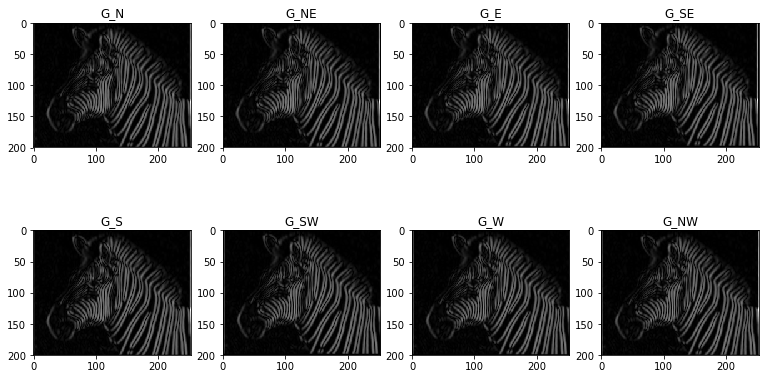

In [6]:
G_N = np.zeros_like(G)  # the North neighbor
G_N[1:,:] = G[:-1,:]

# continue with neighbors on the other 7 directions (S, E, W, NE, NW, SE and SW)

# your code here..
G_S = np.zeros_like(G)  # the South neighbor
G_S[1:,:] = G[:-1,:]
G_W = np.zeros_like(G)  # the West neighbor
G_W[:,1:] = G[:,:-1]
G_E = np.zeros_like(G)  # the East neighbor
G_E[:,:-1] = G[:,1:]
G_NE = np.zeros_like(G)  # the North East neighbor
G_NE[1:,:-1] = G[:-1,1:]
G_NW = np.zeros_like(G)  # the North West neighbor
G_NW[1:,1:] = G[:-1,:-1]
G_SW = np.zeros_like(G)  # the South West neighbor
G_SW[:-1,1:] = G[1:,:-1]
G_SE = np.zeros_like(G)  # the South East neighbor
G_SE[:-1,:-1] = G[1:,1:]

# plot G_NE and G_SW for example, to verify it looks ok..
imgs = [G_N,G_NE,G_E,G_SE,G_S,G_SW,G_W,G_NW]
imgNames = ['G_N','G_NE','G_E','G_SE','G_S','G_SW','G_W','G_NW']
plt.figure(figsize=(13,7))
pltNumber = 1
for i,img_t in enumerate(imgs):
    plt.subplot(2,4,pltNumber)
    plt.imshow(img_t,cmap='gray')
    plt.title('{}'.format(imgNames[i]))
    pltNumber = pltNumber + 1
plt.show()

## step 3: Non-Maxima Suppression (NMS)

first, we will quantize the gradient directions (theta) into 4 orientations
> W-E, NW-SE, N-S, NE-SW

generate a matrix 'T' that assign for each pixel T[y,x] one of the 4 orientations {1,2,3,4}:

$$ T[y,x] \in \{1,2,3,4\} $$

where,

1. W-E
2. NW-SE
3. N-S
4. NE-SW


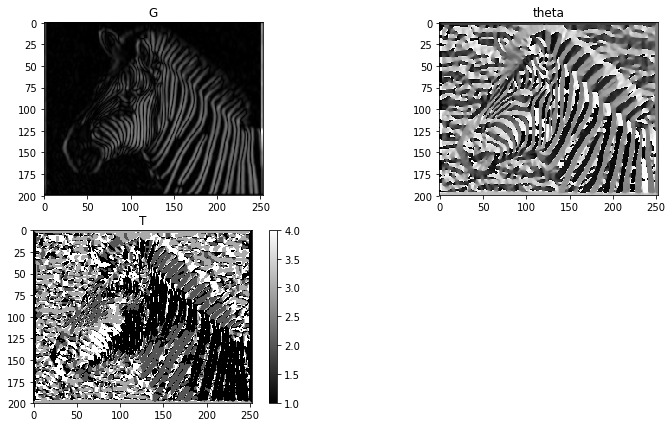

In [7]:
# your code here..
ang = (1+theta/np.pi)*8
T = np.zeros_like(ang)
T[(ang >= 7)*(ang <= 9)+(ang>15)+(ang<1)] = 1 #W-E
T[(ang >= 9)*(ang <= 11)+(ang>=1)*(ang<=3)] = 2 #NW-SE
T[(ang >= 11)*(ang <= 13)+(ang>=3)*(ang<=5)] = 3 #N-S
T[(ang >= 5)*(ang <= 7)+(ang>=13)*(ang<=15)] = 4 #NE-SW
# plot side-by-side: G, theta and T
imgs = [G,theta,T]
imgNames = ['G','theta','T']
plt.figure(figsize=(13,7))
pltNumber = 1
for i,img_t in enumerate(imgs):
    plt.subplot(2,2,pltNumber)
    plt.imshow(img_t,cmap='gray')
    if(i == 2):
        plt.colorbar()
    plt.title('{}'.format(imgNames[i]))
    pltNumber = pltNumber + 1
plt.show()

### next, we perform 'non-maxima suppression': 

`> G[y,x] -> G_nms[y,x]`

for each pixel check its 2-neighbors along its gradient direction.

if its value is maximal among them - keep it (copy it to G_nms)
otherwise - suppress it (put zero value in its position in G_nms)


hint: no need for any loops here, just some logical operations..



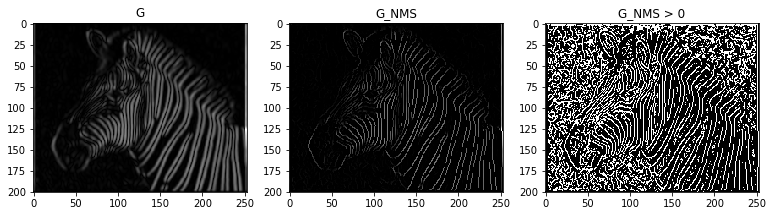

In [8]:
# your code here..
G_NMS = np.zeros_like(G)  # Init G_NMS matrix
msk1 = T == 1 * (G_W<G) * (G_E<G) #W-E
msk2 = T == 2 * (G_NW<G) * (G_SE<G)#NW-SE
msk3 = T == 3 * (G_N<G) * (G_S<G)#N-S
msk4 = T == 4 * (G_NE<G) * (G_SW<G) #NE-SW
G_NMS[msk1] = G[msk1] 
G_NMS[msk2] = G[msk2]
G_NMS[msk3] = G[msk3]
G_NMS[msk4] = G[msk4]
# plot side by side: G, G_nms and G_nms>0
imgs = [G,G_NMS,G_NMS > 0]
imgNames = ['G','G_NMS','G_NMS > 0']
plt.figure(figsize=(13,7))
pltNumber = 1
for i,img_t in enumerate(imgs):
    plt.subplot(1,3,pltNumber)
    plt.imshow(img_t,cmap='gray')
    plt.title('{}'.format(imgNames[i]))
    pltNumber = pltNumber + 1
plt.show()

### step 4: double thresholding 

define two threshold values based on the gradient values in G_nms.

generate a boolean matrix 'strong', for pixels where:
> G_nms[i,j] > th_high

generate a boolean matrix 'weak', for pixels where:
> th_low < G_nms[i,j] < th_high

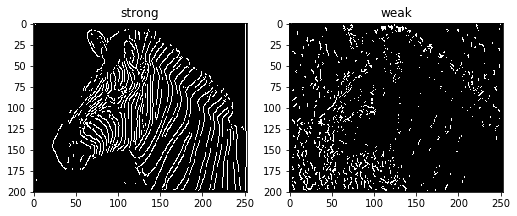

In [29]:
# define two threshold values based on the gradient values in G_nms, 
th_low, th_high = 20,80

# your code here..
strong = G_NMS > th_high
weak =  (th_low< G_NMS) * (G_NMS <th_high) 
# plot both matrices
imgs = [strong,weak]
imgNames = ['strong','weak']
plt.figure(figsize=(13,7))
pltNumber = 1
for i,img_t in enumerate(imgs):
    plt.subplot(1,3,pltNumber)
    plt.imshow(img_t,cmap='gray')
    plt.title('{}'.format(imgNames[i]))
    pltNumber = pltNumber + 1
plt.show()

### finally, generate the (binary) Canny matrix Z_canny:

step A: strong pixels are copied to Z_canny

step B (BONUS): weak pixels converts to strong pixels - if they are connected to a strong pixel
this is an iterative process - until all weak pixels are either converted to strong pixels or suppressed.

- plot the result





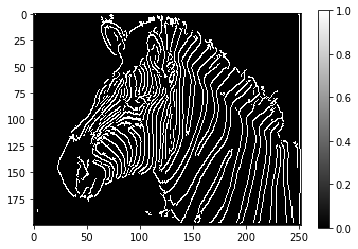

In [33]:
# your code here...
#step B
strongSum = 0
weakSum = 0
while(True) :
   
    strong_S = np.zeros_like(strong)  # the South neighbor
    strong_S[1:,:] = strong[:-1,:]
    strong_W = np.zeros_like(strong)  # the West neighbor
    strong_W[:,1:] = strong[:,:-1]
    strong_E = np.zeros_like(strong)  # the East neighbor
    strong_E[:,:-1] = strong[:,1:]
    strong_NE = np.zeros_like(strong)  # the North East neighbor
    strong_NE[1:,:-1] = strong[:-1,1:]
    strong_NW = np.zeros_like(strong)  # the North West neighbor
    strong_NW[1:,1:] = strong[:-1,:-1]
    strong_SW = np.zeros_like(strong)  # the South West neighbor
    strong_SW[:-1,1:] = strong[1:,:-1]
    strong_SE = np.zeros_like(strong)  # the South East neighbor
    strong_SE[:-1,:-1] = strong[1:,1:]  
    msk = weak *(strong_S+strong_W+strong_E+strong_NE+strong_NW+strong_SW+strong_SE)
    strongSum = strong.sum()
    strong[msk] = True 
    if(strongSum == strong.sum()):
        break
    weakSum = weak.sum()
    weak[msk] = False
    if(weakSum == weak.sum()):
        break
#step A after iterative process has convereged
Z_canny = strong
plt.imshow(Z_canny,cmap='gray')
plt.colorbar()
plt.show()

### X-ray image

load and display the x-ray image.

run the compelete Canny edge algorithm, and play with the free parameters (Gaussian, th_low and th_high) until you find a satisfactory result.



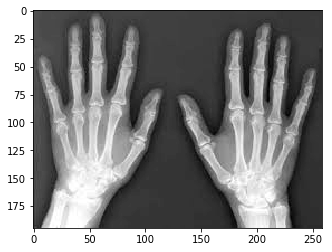

In [34]:
img = imread('xray.jpeg','L')

plt.imshow(img, cmap='gray',interpolation='nearest')
plt.show()

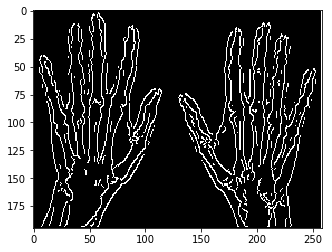

In [37]:
#parameters
th_low, th_high = 25, 80
gaussian_kernel = gaussian(1, 1.5)

#phase 1
Zin = filter2D(img, gaussian_kernel)
#phase 2
Gx = filter2D(Zin, SxWithSmooth)
Gy = filter2D(Zin, SyWithSmooth)
G = np.sqrt(Gx**2 + Gx**2)
theta = np.arctan2(Gy,Gx)
#phase 3
G_N = np.zeros_like(G)  # the North neighbor
G_N[1:,:] = G[:-1,:]
G_S = np.zeros_like(G)  # the South neighbor
G_S[1:,:] = G[:-1,:]
G_W = np.zeros_like(G)  # the West neighbor
G_W[:,1:] = G[:,:-1]
G_E = np.zeros_like(G)  # the East neighbor
G_E[:,:-1] = G[:,1:]
G_NE = np.zeros_like(G)  # the North East neighbor
G_NE[1:,:-1] = G[:-1,1:]
G_NW = np.zeros_like(G)  # the North West neighbor
G_NW[1:,1:] = G[:-1,:-1]
G_SW = np.zeros_like(G)  # the South West neighbor
G_SW[:-1,1:] = G[1:,:-1]
G_SE = np.zeros_like(G)  # the South East neighbor
G_SE[:-1,:-1] = G[1:,1:]
ang = (1+theta/np.pi)*8
T = np.zeros_like(ang)
T[(ang >= 7)*(ang <= 9)+(ang>15)+(ang<1)] = 1 #W-E
T[(ang >= 9)*(ang <= 11)+(ang>=1)*(ang<=3)] = 2 #NW-SE
T[(ang >= 11)*(ang <= 13)+(ang>=3)*(ang<=5)] = 3 #N-S
T[(ang >= 5)*(ang <= 7)+(ang>=13)*(ang<=15)] = 4 #NE-SW
G_NMS = np.zeros_like(G)  # Init G_NMS matrix
msk1 = T == 1 * (G_W<G) * (G_E<G) #W-E
msk2 = T == 2 * (G_NW<G) * (G_SE<G)#NW-SE
msk3 = T == 3 * (G_N<G) * (G_S<G)#N-S
msk4 = T == 4 * (G_NE<G) * (G_SW<G) #NE-SW
G_NMS[msk1] = G[msk1] 
G_NMS[msk2] = G[msk2]
G_NMS[msk3] = G[msk3]
G_NMS[msk4] = G[msk4]
#phase 4
strong = G_NMS > th_high
weak =  (th_low< G_NMS) * (G_NMS <th_high) 
#phase 4 - step B
#step B
strongSum = 0
weakSum = 0
while(True) : 
    strong_S = np.zeros_like(strong)  # the South neighbor
    strong_S[1:,:] = strong[:-1,:]
    strong_W = np.zeros_like(strong)  # the West neighbor
    strong_W[:,1:] = strong[:,:-1]
    strong_E = np.zeros_like(strong)  # the East neighbor
    strong_E[:,:-1] = strong[:,1:]
    strong_NE = np.zeros_like(strong)  # the North East neighbor
    strong_NE[1:,:-1] = strong[:-1,1:]
    strong_NW = np.zeros_like(strong)  # the North West neighbor
    strong_NW[1:,1:] = strong[:-1,:-1]
    strong_SW = np.zeros_like(strong)  # the South West neighbor
    strong_SW[:-1,1:] = strong[1:,:-1]
    strong_SE = np.zeros_like(strong)  # the South East neighbor
    strong_SE[:-1,:-1] = strong[1:,1:]  
    msk = weak *(strong_S+strong_W+strong_E+strong_NE+strong_NW+strong_SW+strong_SE)
    strongSum = strong.sum()
    strong[msk] = True 
    if(strongSum == strong.sum()):
        break
    weakSum = weak.sum()
    weak[msk] = False
    if(weakSum == weak.sum()):
        break
Zout = strong
plt.imshow(Zout, cmap='gray',interpolation='nearest')
plt.show()

# Good luck !